### WRF stream files

We have set WRF to output a few 2D variables to be output every 10 minutes on domains 2 and 3 in what WRF calls *stream* files.

This script follows the exact same stucture of `AWS_WRF_comparison.ipynb` with the descriptions ommitted apart from a discussion of how we handle the stream files.

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import glob
from netCDF4 import Dataset
import os

In [2]:
import sys
sys.path.append('/data/shared_data/scripts/ammss/')
from MultiLineSubPlotter import MultiLineSubplotter, VerticalPlotter, HorizontalPlotter
from Interpolator import Interpolator

In [3]:
path = '/data/shared_data/observations/Davis-weather-station/CUSTOM-ARC-2024-05-14-METRIC.csv'

aws_data = pd.read_csv(path, delimiter=',')

In [4]:
measurements = [column.split(' ')[0] for column in aws_data.columns]
units = [column.split(' ')[-1] for column in aws_data.columns]

In [5]:
measurements = [string.replace('%', '') for string in measurements]

In [6]:
units = [string.replace('Humid', '').replace('Inside','') for string in units]
units[-1] = 'index'

In [7]:
units_lookup = {}
for (key, val) in zip(measurements, units):
    units_lookup[key]=val

In [8]:
aws_data.columns = measurements

In [9]:
aws_data['Timestamp'] = [dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in aws_data['Timestamp'].to_numpy().flatten().tolist()]

In [10]:
def wrfout_time(filename):
    """
    Returns a date time object based on wrf file name
    """
    split_count = filename.count('_')
    
    time = dt.datetime.strptime(filename.split('_',split_count-1)[-1], '%Y-%m-%d_%H:%M:%S')
    return time

In [11]:
# Get time bounds from Obs data
init_time = aws_data.iat[0, 0].to_pydatetime()
final_time = aws_data.iat[-1, 0].to_pydatetime()

def wrfout_inside_time(filename):
    """ 
    boolean, Filters wrfout files such that only files valid in a time range
    """
    return init_time <= wrfout_time(filename) and wrfout_time(filename) <= final_time

In [12]:
path = '/data/shared_data/model/2024051312/'
os.chdir(path)

In [13]:
all_streams = glob.glob('stream_7_d03*')
all_streams[:10]

['stream_7_d03_2024-05-13_12:00:00',
 'stream_7_d03_2024-05-13_13:00:00',
 'stream_7_d03_2024-05-13_14:00:00',
 'stream_7_d03_2024-05-13_15:00:00',
 'stream_7_d03_2024-05-13_16:00:00',
 'stream_7_d03_2024-05-13_17:00:00',
 'stream_7_d03_2024-05-13_18:00:00',
 'stream_7_d03_2024-05-13_19:00:00',
 'stream_7_d03_2024-05-13_20:00:00',
 'stream_7_d03_2024-05-13_21:00:00']

In [14]:
all_streams.sort()
intime_streams = [path + filename for filename in list(filter(wrfout_inside_time, all_streams))]

datasets = [Dataset(wrfout, 'r+', diskless=True) for wrfout in intime_streams]

### Looking at the structure of a stream file

If we take a look at the available variables, we have much less than a generic wrfout.

In [15]:
datasets[0].variables.keys()

dict_keys(['Times', 'Q2', 'T2', 'PSFC', 'U10', 'V10', 'PBLH'])

Notice that we do not have latitiude or longitude variables - we will need to add these to do any analysis using wrf-python!

Why do you think latitude and longitude have not been included?

### Adding the spacial coordinates

Let's upload a full wrfout from the current directory and look at the variables.

In [16]:
full_wrfout = Dataset('wrfout_d03_2024-05-13_12:00:00')

In [17]:
full_wrfout.variables.keys()

dict_keys(['Times', 'XLAT', 'XLONG', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'VAR_SSO', 'BATHYMETRY_FLAG', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'THM', 'HFX_FORCE', 'LH_FORCE', 'TSK_FORCE', 'HFX_FORCE_TEND', 'LH_FORCE_TEND', 'TSK_FORCE_TEND', 'MU', 'MUB', 'NEST_POS', 'P', 'PB', 'FNM', 'FNP', 'RDNW', 'RDN', 'DNW', 'DN', 'CFN', 'CFN1', 'THIS_IS_AN_IDEAL_RUN', 'P_HYD', 'Q2', 'T2', 'TH2', 'PSFC', 'U10', 'V10', 'RDX', 'RDY', 'AREA2D', 'DX2D', 'RESM', 'ZETATOP', 'CF1', 'CF2', 'CF3', 'ITIMESTEP', 'XTIME', 'QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 'QNICE', 'QNSNOW', 'QNRAIN', 'QNGRAUPEL', 'SHDMAX', 'SHDMIN', 'SNOALB', 'TSLB', 'SMOIS', 'SH2O', 'SMCREL', 'SEAICE', 'XICEM', 'SFROFF', 'UDROFF', 'IVGTYP', 'ISLTYP', 'VEGFRA', 'GRDFLX', 'ACGRDFLX', 'ACSNOM', 'SNOW', 'SNOWH', 'CANWAT', 'SSTSK', 'WATER_DEPTH', 'COSZEN', 'LAI', 'U10E', 'V10E', 'VAR', 'TKE_PBL', 'EL_PBL', 'MAPFAC_M', 'MAPFAC_U', 'MAPFAC_V', 'MAPFAC_MX', 'MAPFAC_MY', 'MAPFAC_UX', 'MAPFAC_UY', 'MAPFAC_VX', 'MF_VX_INV', 'MAPFAC_VY',

Here are the latitude or 'XLAT' and longitude or 'XLONG' variables:

In [18]:
full_wrfout.variables['XLAT'], full_wrfout.variables['XLONG']

(<class 'netCDF4._netCDF4.Variable'>
 float32 XLAT(Time, south_north, west_east)
     FieldType: 104
     MemoryOrder: XY 
     description: LATITUDE, SOUTH IS NEGATIVE
     units: degree_north
     stagger: 
     coordinates: XLONG XLAT
 unlimited dimensions: Time
 current shape = (1, 145, 320)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 <class 'netCDF4._netCDF4.Variable'>
 float32 XLONG(Time, south_north, west_east)
     FieldType: 104
     MemoryOrder: XY 
     description: LONGITUDE, WEST IS NEGATIVE
     units: degree_east
     stagger: 
     coordinates: XLONG XLAT
 unlimited dimensions: Time
 current shape = (1, 145, 320)
 filling on, default _FillValue of 9.969209968386869e+36 used)

For each of the stream files, we will create new variables 'XLAT' and 'XLONG' and populate them with the data from the full wrfout

In [19]:
for dataset in datasets:
    dataset.createVariable('XLAT', 'f4', ('Time', 'south_north', 'west_east'))
    dataset.variables['XLAT'] = full_wrfout.variables['XLAT']
    dataset.createVariable('XLONG', 'f4', ('Time', 'south_north', 'west_east'))
    dataset.variables['XLONG'] = full_wrfout.variables['XLONG']

### Using wrf-python to load and interpolate our wrf data to the aws location

In [20]:
from wrf import getvar, ll_to_xy, ALL_TIMES

grid_ref_flt = ll_to_xy(datasets[0], 54.620538, -3.080279, as_int=False)
grid_ref_int = ll_to_xy(datasets[0], 54.620538, -3.080279, as_int=True)

In [21]:
interps_flt = Interpolator(grid_ref_flt[1], grid_ref_flt[0])

In [22]:
T2 = getvar(datasets, 'T2', timeidx=None, method='cat')
RH = getvar(datasets, 'rh2', timeidx=None, method='cat')

In [23]:
T2_flt = np.array([interps_flt.interp(twodarr) for twodarr in T2.to_numpy()])-273.15
T2_int = np.array([twodarr[grid_ref_int[0], grid_ref_int[1]] for twodarr in T2.to_numpy()])-273.15

RH_flt = np.array([interps_flt.interp(twodarr) for twodarr in RH.to_numpy()])
RH_int = np.array([twodarr[grid_ref_int[0], grid_ref_int[1]] for twodarr in RH.to_numpy()])


### Plotting

In [24]:
temp_lines_all = [
    {
        'x': aws_data['Timestamp'].to_numpy().flatten(),
        'y': aws_data['Temp'].to_numpy().flatten(),
        'label': 'AWS',
        'color': 'r',
        'linestyle': '-',
        'marker': ''
    },
    {
        'x': T2.coords['Time'].to_numpy(),
        'y': T2_int,
        'label': 'WRF, nearest gridpoint',
        'color': 'orange',
        'linestyle': '',
        'marker': '.'

    },
    {
        'x': T2.coords['Time'].to_numpy(),
        'y': T2_flt,
        'label': 'WRF, interpolated',
        'color': 'b',
        'linestyle': '',
        'marker': '.'

    }
]

rh_lines_all = [
    {
        'x': aws_data['Timestamp'].to_numpy().flatten(),
        'y': aws_data['Humid'].to_numpy().flatten(),
        'label': 'AWS',
        'color': 'r',
        'linestyle': '-',
        'marker': ''
    },
    {
        'x': RH.coords['Time'].to_numpy(),
        'y': RH_int,
        'label': 'WRF, nearest gridpoint',
        'color': 'orange',
        'linestyle': '',
        'marker': '.'
    },
    {
        'x': RH.coords['Time'].to_numpy(),
        'y': RH_flt,
        'label': 'WRF, interpolated',
        'color': 'b',
        'linestyle': '',
        'marker': '.'

    }
]

In [43]:
plot = VerticalPlotter((20, 4), 4,  'WRF vs AWS 14th May', space_between=0.5)

In [45]:
plot.add_plot(temp_lines_all, f"Temperature\n{units_lookup['Temp']}", legend=True)
plot.add_plot(rh_lines_all, f"Rel. Hum. \n{units_lookup['Humid']}", legend=True)

12.42532036103978 15.7
11.770384433247736 16.35493592779204
88.0 98.88767
85.82246551513671 101.0652069091797


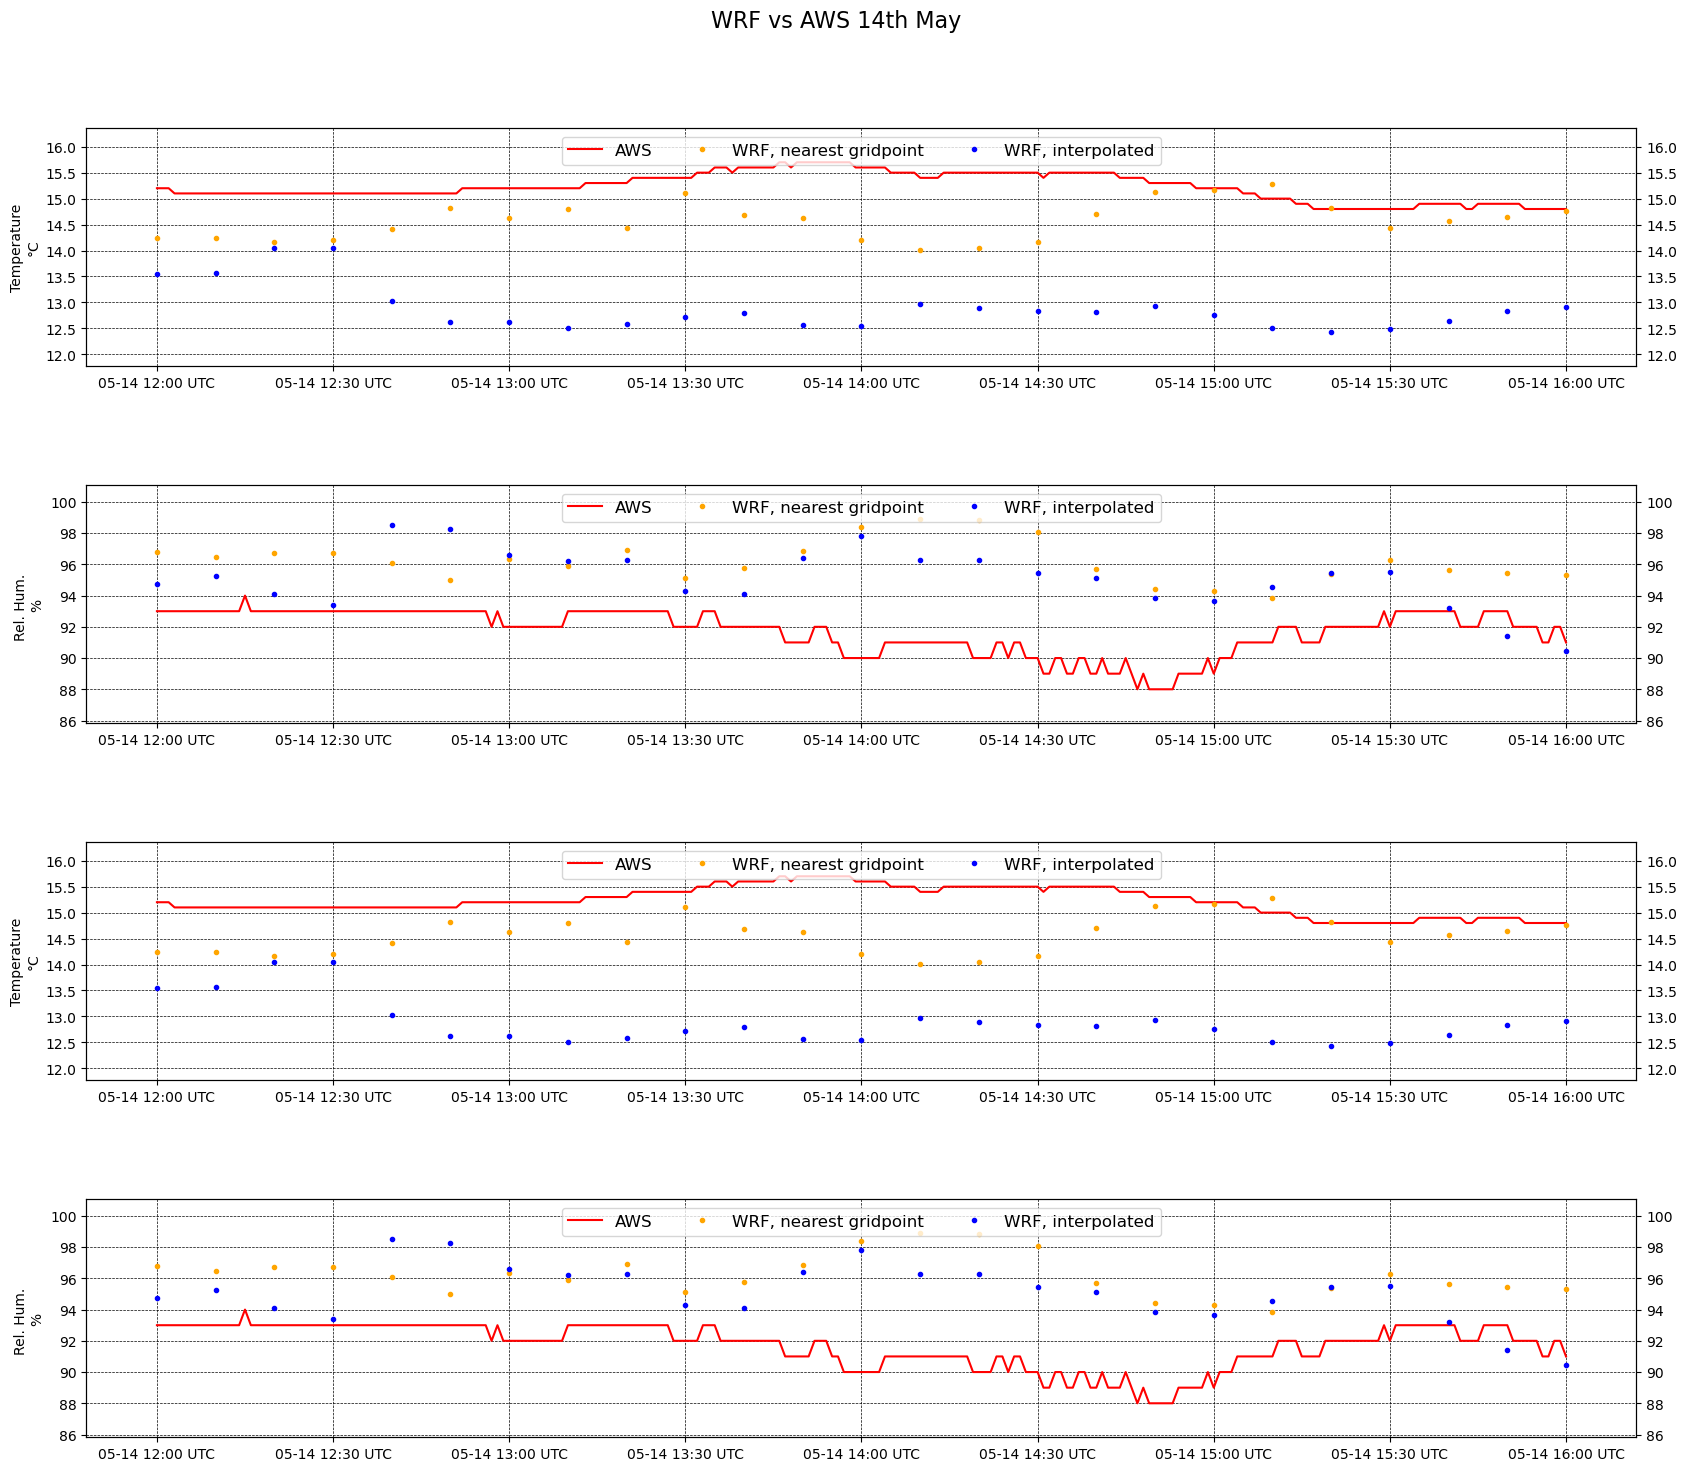

In [46]:
plot.fig

In [28]:
plot = VerticalPlotter((20, 4), 2, 'WRF vs AWS 14th May', space_between=0.5)

In [29]:
time_bound = (
    dt.datetime(year=2024, month=5, day=14, hour=12),
    dt.datetime(year=2024, month=5, day=14, hour=16)
)

12.42532036103978 15.7
11.770384433247736 16.35493592779204
88.0 98.88767
85.82246551513671 101.0652069091797


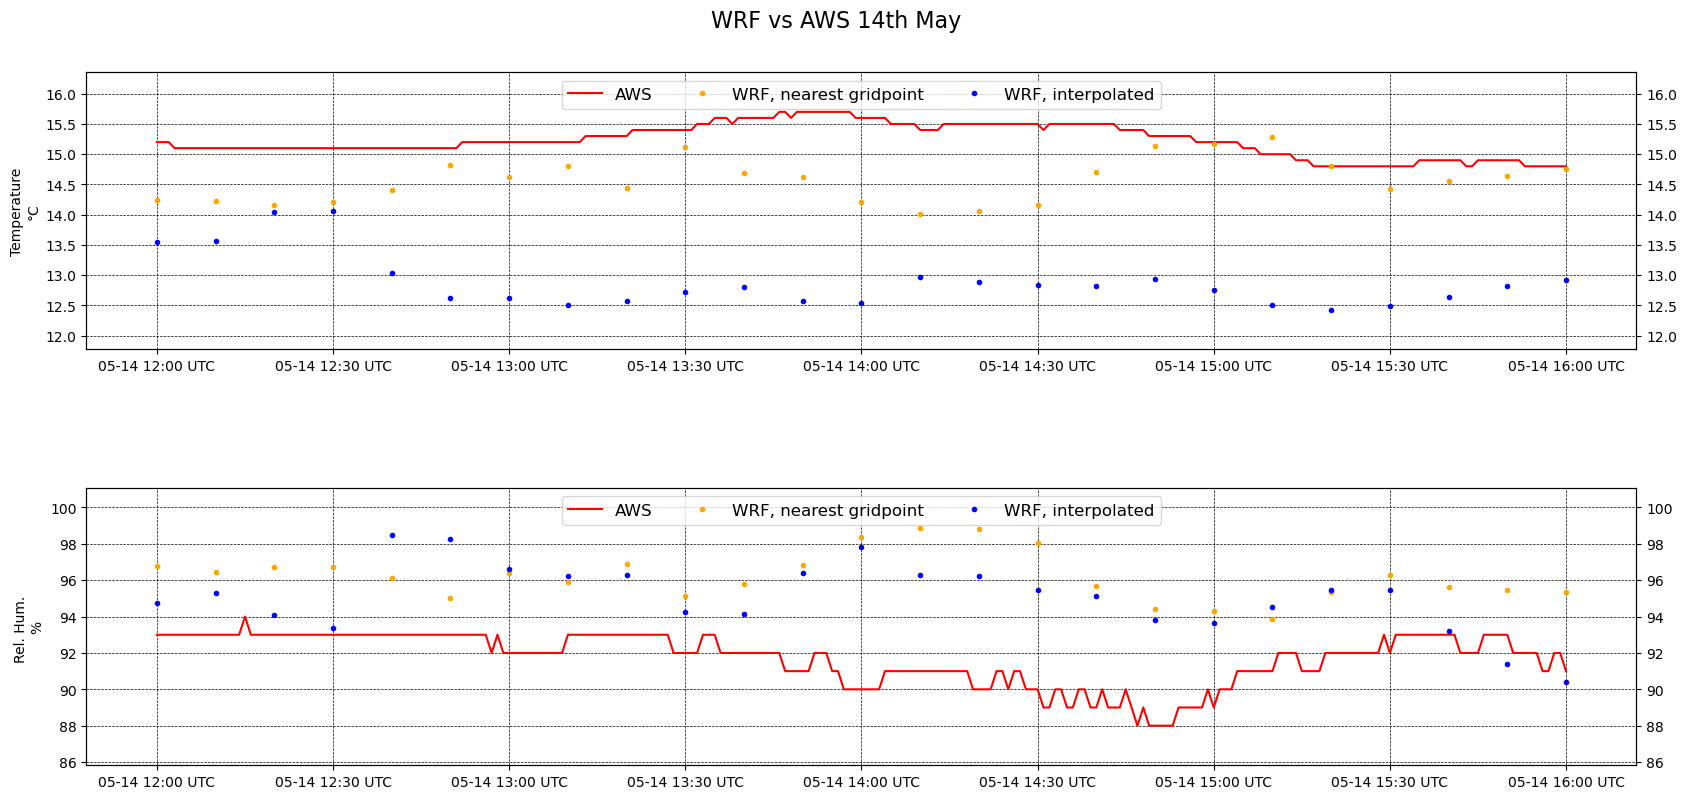

In [30]:
plot.add_plot(temp_lines_all, f"Temperature\n{units_lookup['Temp']}", legend=True, time_bound=time_bound)
plot.add_plot(rh_lines_all, f"Rel. Hum. \n{units_lookup['Humid']}", legend=True, time_bound=time_bound)